<a href="https://colab.research.google.com/github/w1767/PhD/blob/main/Hurst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Hurst exponent evaluation and R/S-analysis

hurst is a small Python module for analysing random walks and evaluating the Hurst exponent (H).

H = 0.5 — Brownian motion,
0.5 < H < 1.0 — persistent behavior,
0 < H < 0.5 — anti-persistent behavior.

Install hurst module with
pip install hurst

In [2]:
!pip install hurst

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


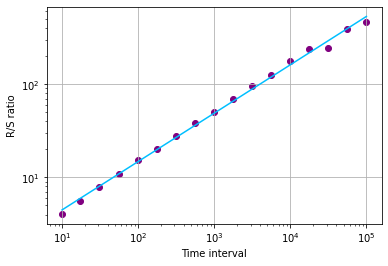

H=0.5183, c=1.3587


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from hurst import compute_Hc, random_walk

# Use random_walk() function or generate a random walk series manually:
# series = random_walk(99999, cumprod=True)
np.random.seed(42)
random_changes = 1. + np.random.randn(99999) / 1000.
series = np.cumprod(random_changes)  # create a random walk from random changes

# Evaluate Hurst equation
H, c, data = compute_Hc(series, kind='price', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))


Kinds of series
The kind parameter of the compute_Hc function can have the following values:
'change': a series is just random values (i.e. np.random.randn(...))
'random_walk': a series is a cumulative sum of changes (i.e. np.cumsum(np.random.randn(...)))
'price': a series is a cumulative product of changes (i.e. np.cumprod(1+epsilon*np.random.randn(...))

Brownian motion, persistent and antipersistent random walks

In [4]:
#You can generate random walks with random_walk() function as following:
#Brownian
brownian = random_walk(99999, proba=0.5)

In [5]:
#persistent
persistent = random_walk(99999, proba=0.7)

In [6]:
#antipersistent
antipersistent = random_walk(99999, proba=0.3)

In [7]:
#!/usr/bin/env python3
# -*- coding: UTF-8 -*-

"""
Hurst exponent and RS-analysis
https://en.wikipedia.org/wiki/Hurst_exponent
https://en.wikipedia.org/wiki/Rescaled_range
"""

name = "hurst"
__version__ = '0.0.5'

import sys
import math
import warnings
import numpy as np
try:
    import pandas as pd
except:
    pass

def __to_inc(x):
    incs = x[1:] - x[:-1]
    return incs

def __to_pct(x):
    pcts = x[1:] / x[:-1] - 1.
    return pcts

def __get_simplified_RS(series, kind):
    """
    Simplified version of rescaled range

    Parameters
    ----------

    series : array-like
        (Time-)series
    kind : str
        The kind of series (refer to compute_Hc docstring)
    """

    if kind == 'random_walk':
        incs = __to_inc(series)
        R = max(series) - min(series)  # range in absolute values
        S = np.std(incs, ddof=1)
    elif kind == 'price':
        pcts = __to_pct(series)
        R = max(series) / min(series) - 1. # range in percent
        S = np.std(pcts, ddof=1)
    elif kind == 'change':
        incs = series
        _series = np.hstack([[0.],np.cumsum(incs)])
        R = max(_series) - min(_series)  # range in absolute values
        S = np.std(incs, ddof=1)

    if R == 0 or S == 0:
        return 0  # return 0 to skip this interval due the undefined R/S ratio

    return R / S

def __get_RS(series, kind):
    """
    Get rescaled range (using the range of cumulative sum
    of deviations instead of the range of a series as in the simplified version
    of R/S) from a time-series of values.

    Parameters
    ----------

    series : array-like
        (Time-)series
    kind : str
        The kind of series (refer to compute_Hc docstring)
    """

    if kind == 'random_walk':
        incs = __to_inc(series)
        mean_inc = (series[-1] - series[0]) / len(incs)
        deviations = incs - mean_inc
        Z = np.cumsum(deviations)
        R = max(Z) - min(Z)
        S = np.std(incs, ddof=1)

    elif kind == 'price':
        incs = __to_pct(series)
        mean_inc = np.sum(incs) / len(incs)
        deviations = incs - mean_inc
        Z = np.cumsum(deviations)
        R = max(Z) - min(Z)
        S = np.std(incs, ddof=1)

    elif kind == 'change':
        incs = series
        mean_inc = np.sum(incs) / len(incs)
        deviations = incs - mean_inc
        Z = np.cumsum(deviations)
        R = max(Z) - min(Z)
        S = np.std(incs, ddof=1)

    if R == 0 or S == 0:
        return 0  # return 0 to skip this interval due undefined R/S

    return R / S

def compute_Hc(series, kind="random_walk", min_window=10, max_window=None, simplified=True):
    """
    Compute H (Hurst exponent) and C according to Hurst equation:
    E(R/S) = c * T^H

    Refer to:
    https://en.wikipedia.org/wiki/Hurst_exponent
    https://en.wikipedia.org/wiki/Rescaled_range
    https://en.wikipedia.org/wiki/Random_walk

    Parameters
    ----------

    series : array-like
        (Time-)series

    kind : str
        Kind of series
        possible values are 'random_walk', 'change' and 'price':
        - 'random_walk' means that a series is a random walk with random increments;
        - 'price' means that a series is a random walk with random multipliers;
        - 'change' means that a series consists of random increments
            (thus produced random walk is a cumulative sum of increments);

    min_window : int, default 10
        the minimal window size for R/S calculation

    max_window : int, default is the length of series minus 1
        the maximal window size for R/S calculation

    simplified : bool, default True
        whether to use the simplified or the original version of R/S calculation

    Returns tuple of
        H, c and data
        where H and c — parameters or Hurst equation
        and data is a list of 2 lists: time intervals and R/S-values for correspoding time interval
        for further plotting log(data[0]) on X and log(data[1]) on Y
    """

    if len(series)<100:
        raise ValueError("Series length must be greater or equal to 100")

    ndarray_likes = [np.ndarray]
    if "pandas.core.series" in sys.modules.keys():
        ndarray_likes.append(pd.core.series.Series)

    # convert series to numpy array if series is not numpy array or pandas Series
    if type(series) not in ndarray_likes:
        series = np.array(series)

    if "pandas.core.series" in sys.modules.keys() and type(series) == pd.core.series.Series:
        if series.isnull().values.any():
            raise ValueError("Series contains NaNs")
        series = series.values  # convert pandas Series to numpy array
    elif np.isnan(np.min(series)):
        raise ValueError("Series contains NaNs")

    if simplified:
        RS_func = __get_simplified_RS
    else:
        RS_func = __get_RS


    err = np.geterr()
    np.seterr(all='raise')

    max_window = max_window or len(series)-1
    window_sizes = list(map(
        lambda x: int(10**x),
        np.arange(math.log10(min_window), math.log10(max_window), 0.25)))
    window_sizes.append(len(series))

    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(series), w):
            if (start+w)>len(series):
                break
            _ = RS_func(series[start:start+w], kind)
            if _ != 0:
                rs.append(_)
        RS.append(np.mean(rs))

    A = np.vstack([np.log10(window_sizes), np.ones(len(RS))]).T
    H, c = np.linalg.lstsq(A, np.log10(RS), rcond=-1)[0]
    np.seterr(**err)

    c = 10**c
    return H, c, [window_sizes, RS]

def random_walk(length, proba=0.5, min_lookback=1, max_lookback=100, cumprod=False):
    """
    Generates a random walk series

    Parameters
    ----------

    proba : float, default 0.5
        the probability that the next increment will follow the trend.
        Set proba > 0.5 for the persistent random walk,
        set proba < 0.5 for the antipersistent one

    min_lookback: int, default 1
    max_lookback: int, default 100
        minimum and maximum window sizes to calculate trend direction
    cumprod : bool, default False
        generate a random walk as a cumulative product instead of cumulative sum
    """

    assert(min_lookback>=1)
    assert(max_lookback>=min_lookback)

    if max_lookback > length:
        max_lookback = length
        warnings.warn("max_lookback parameter has been set to the length of the random walk series.")

    if not cumprod:  # ordinary increments
        series = [0.] * length  # array of prices
        for i in range(1, length):
            if i < min_lookback + 1:
                direction = np.sign(np.random.randn())
            else:
                lookback = np.random.randint(min_lookback, min(i-1, max_lookback)+1)
                direction = np.sign(series[i-1] - series[i-1-lookback]) * np.sign(proba - np.random.uniform())
            series[i] = series[i-1] + np.fabs(np.random.randn()) * direction
    else:  # percent changes
        series = [1.] * length  # array of prices
        for i in range(1, length):
            if i < min_lookback + 1:
                direction = np.sign(np.random.randn())
            else:
                lookback = np.random.randint(min_lookback, min(i-1, max_lookback)+1)
                direction = np.sign(series[i-1] / series[i-1-lookback] - 1.) * np.sign(proba - np.random.uniform())
            series[i] = series[i-1] * np.fabs(1 + np.random.randn()/1000. * direction)

    return series


if __name__ == '__main__':

    # Use random_walk() function or generate a random walk series manually:
    # series = random_walk(99999, cumprod=True)
    np.random.seed(42)
    random_changes = 1. + np.random.randn(99999) / 1000.
    series = np.cumprod(random_changes)  # create a random walk from random changes

    # Evaluate Hurst equation
    H, c, data = compute_Hc(series, kind='price', simplified=True)

    # Plot
    # uncomment the following to make a plot using Matplotlib:
    """
    import matplotlib.pyplot as plt

    f, ax = plt.subplots()
    ax.plot(data[0], c*data[0]**H, color="deepskyblue")
    ax.scatter(data[0], data[1], color="purple")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Time interval')
    ax.set_ylabel('R/S ratio')
    ax.grid(True)
    plt.show()
    """

    print("H={:.4f}, c={:.4f}".format(H,c))
    assert H<0.6 and H>0.4


H=0.5183, c=1.3587


In [8]:
!pip install yfinance
!pip install fix_yahoo_finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import numpy as np
from statsmodels.tsa.stattools import adfuller
pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from datetime import datetime
import time
%matplotlib inline
from dateutil import parser
start, end = datetime(1900, 1, 3), datetime(2022, 8, 4)


spy = pdr.get_data_yahoo(['^GSPC'], start,  end)
spy.columns = [col[0].lower().replace(' ', '_')
                for col in spy.columns]



[*********************100%***********************]  1 of 1 completed


In [50]:
spy

,o,h,l,c,a,v
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...
2022-07-28,4026.129883,4078.949951,3992.969971,4072.429932,4072.429932,3882850000
2022-07-29,4087.330078,4140.149902,4079.219971,4130.290039,4130.290039,3817740000
2022-08-01,4112.379883,4144.950195,4096.020020,4118.629883,4118.629883,3540960000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  del sys.path[0]


hurst =  0.472766664249629


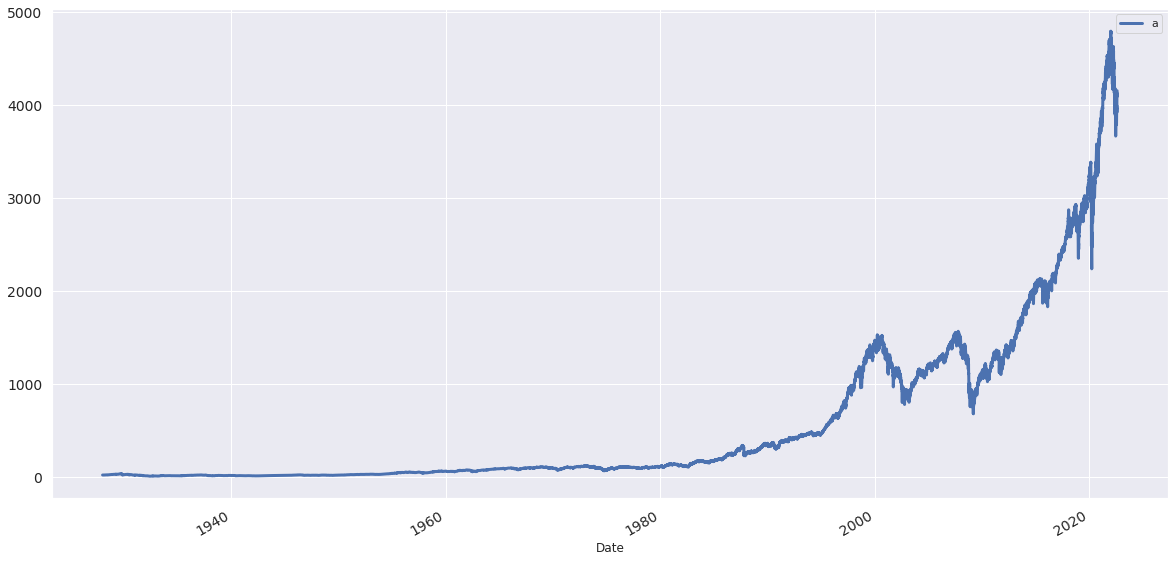

In [51]:
spy_close = spy[['a']]

_ = spy_close.plot(figsize=(20, 10),
                    linewidth=3,
                    fontsize=14)

from numpy import cumsum, log, polyfit, sqrt, std, subtract
import seaborn as sns
sns.set();
spy_close = spy[['a']].copy()
lag1, lag2  = 2, 20
lags = range(lag1, lag2)
tau = [sqrt(std(subtract(spy_close[lag:], spy_close[:-lag]))) for lag in lags]
m = polyfit(log(lags), log(tau), 1)
hurst = m[0]*2
print( 'hurst = ',hurst[0])